# Earthquake location as an inverse problem

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/tsonpham/ObsSeisHUS2025/blob/master/Day3/D3_Prac.ipynb)

Prepared by Thanh-Son Pham (thanhson.pham@anu.edu.au), April 2025.

---
## What we do in this notebook

Here we demonstrate the earthquake hypocentre determination problem casted as an inverse problem.

Learning outcomes include:
- State the inverse problem for the hypocentre determination
- Solve the inverse problem in the optimal framework, by minimizing a misfit function
- Solve the inverse problem in the Bayesian framework with an advanced stochastic sampler

In [19]:
# Environment setup (uncomment code below)

# !pip install emcee obspy

In [1]:
#@title Notebook visualisation settings

%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 10

--- 
## Preparation
First, we will follow the recipe described in the practical excercise from Day 2 to download waveform data of the M5 Kon Tum 28/07/2024 earthquake to demonstrate the example.

In [2]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.mass_downloader import CircularDomain, Restrictions, MassDownloader

# Initialize the client for ISC
isc = Client("ISC")
# Request event information
event = isc.get_events(eventid="641665444")[0]
origin_time = event.preferred_origin().time
origin_lat = event.preferred_origin().latitude
origin_lon = event.preferred_origin().longitude

# Circular domain around the epicenter
domain = CircularDomain(origin_lat, origin_lon, minradius=0.0, maxradius=15.0)
# Restriction on the waveform data
restrictions = Restrictions(
    starttime=origin_time - 1 * 60,
    endtime=origin_time + 10 * 60,
    reject_channels_with_gaps=True,
    minimum_length=0.95,
    minimum_interstation_distance_in_m=150E3,
    channel_priorities=["BH[ZNE12XY]", "HH[ZNE]"],
    location_priorities=["", "00", "10"])

# Initialize the mass downloader with specific providers
mdl = MassDownloader(providers=['IRIS'])
# mdl.download(domain, restrictions, mseed_storage="waveforms", stationxml_storage="stations")

[2025-04-09 06:43:31,119] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2025-04-09 06:43:32,052] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): IRIS.


Next, we load all waveforms and metadata into memory.

In [3]:
from obspy import read_inventory, read, Inventory, Stream
from pathlib import Path
## Read all the stationxml files and merge them into one Inventory object
inv = Inventory()
for file in Path("stations").glob("*.xml"): inv += read_inventory(str(file))
## Read all the waveform files and merge them into one Stream object
dstream = Stream()
for file in Path("waveforms").glob("*.mseed"): dstream += read(str(file))

Let's plot the locations of the cataloged event and available seismic stations on the map.

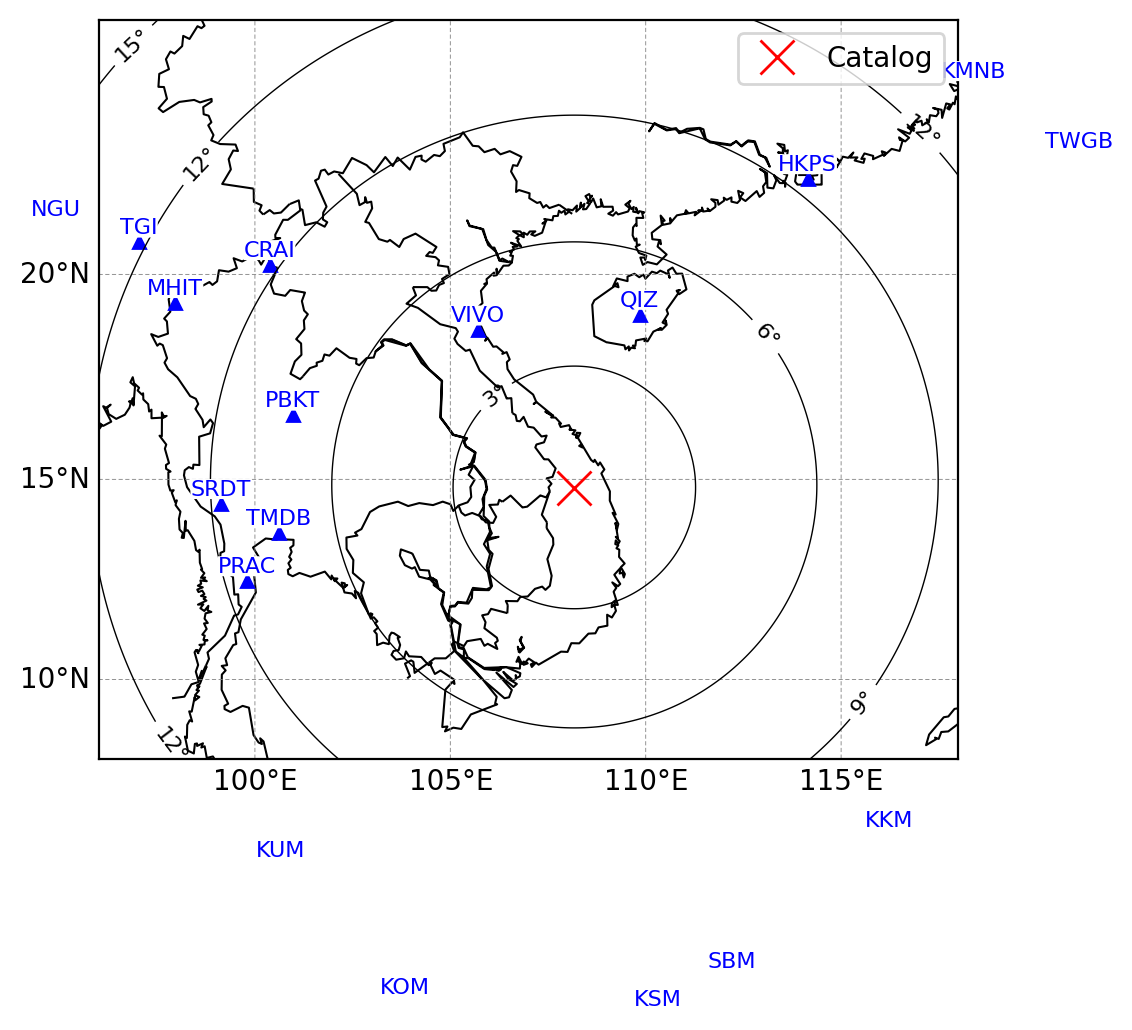

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
from obspy.geodetics import locations2degrees

## define a function to plot station map
def plot_map(inv, event, contour=False):
    # create a new figure and axis
    fig, ax = plt.subplots()
    # initialize the basemap, specifing the projection, the gegraphic buondary, and resolution
    # the initialzed map instance is attached to the axis
    m = Basemap(projection='merc', ax=ax, llcrnrlat=8, urcrnrlat=26,
                llcrnrlon=96, urcrnrlon=118, resolution='l')
    # draw coastlines
    m.drawcoastlines(linewidth=0.75)
    # draw country boundaries
    m.drawcountries(linewidth=0.75)
    # draw parallels and meridians
    m.drawparallels(range(0, 25, 5), labels=[1,0,0,0], linewidth=0.3, color='gray', dashes=(5, 3))
    m.drawmeridians(range(90, 125, 5), labels=[0,0,0,1], linewidth=0.3, color='gray', dashes=(5, 3))
    # plot the epicenter
    m.plot(event.preferred_origin().longitude, event.preferred_origin().latitude, 
           'rx', markersize=12, label='Catalog', latlon=True)
    # plot the station locations
    for network in inv:
        for station in network:
            lon = station.longitude
            lat = station.latitude
            # mark the station location
            m.plot(lon, lat, '^', c='b', markersize=4, latlon=True)
            # put the station label
            x, y = m(lon, lat)
            ax.text(x, y+2.5e4, station.code, fontsize=8, color='b', ha='center',
                    bbox=dict(fc='white', ec='none', boxstyle='round,pad=0.0'))
    if contour:
        # plot distance contours to the epicenter
        x = np.linspace(m.xmin, m.xmax, 300)
        y = np.linspace(m.ymin, m.ymax, 300)
        mlon, mlat = m(*np.meshgrid(x, y), inverse=True)
        dist = locations2degrees(origin_lat, origin_lon, mlat, mlon)
        c = m.contour(mlon, mlat, dist, levels=range(0, 19, 3), latlon=True, colors='k', linewidths=0.5)
        plt.clabel(c, inline=1, fontsize=8, fmt='%d°', colors='k')
    # return the map instance
    return m

# plot the station map
m = plot_map(inv, event, True)
m.ax.legend(loc='upper right')
plt.show()

---
## Seismic observations: Differences of S- and P-wave arrivals

Let's reuse the measurement of P and S wave arrivals from Day 2 practical note book and define a dictionary named `obs_data`. Each dictionary entry corresponding to a station containting the station's coordinate, and S-to-P differential travel time.

In [5]:
from obspy import UTCDateTime

# Picked P and S arrival times for stations QIZ, VIVO, and PBKT as done in the Day 2 practical notebook
obs_data = {
    'QIZ':  {'parv': UTCDateTime(2024,7,28,4,36,20), 'sarv': UTCDateTime(2024,7,28,4,37,9)},
    'VIVO': {'parv': UTCDateTime(2024,7,28,4,36,37), 'sarv': UTCDateTime(2024,7,28,4,37,35)},
    'PBKT': {'parv': UTCDateTime(2024,7,28,4,37,0), 'sarv': UTCDateTime(2024,7,28,4,38,20)}
    }

# update the station coordinates from the inventory
for key, value in obs_data.items():
    tmp = inv.select(station=key)
    obs_data[key].update({'lat': tmp[0][0].latitude, 'lon': tmp[0][0].longitude, 'tdiff': value['sarv'] - value['parv']})

Now we plot the waveform and picked times for visual inspection.

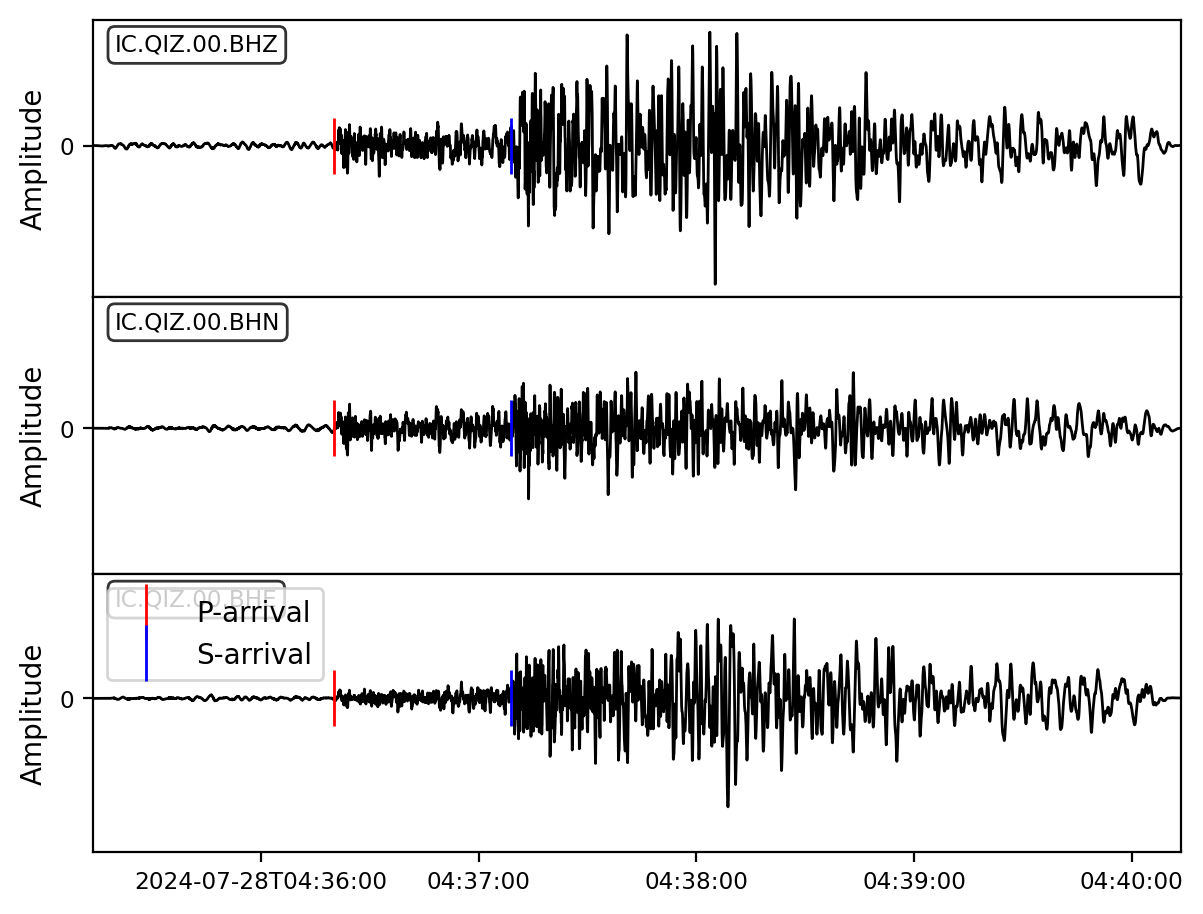

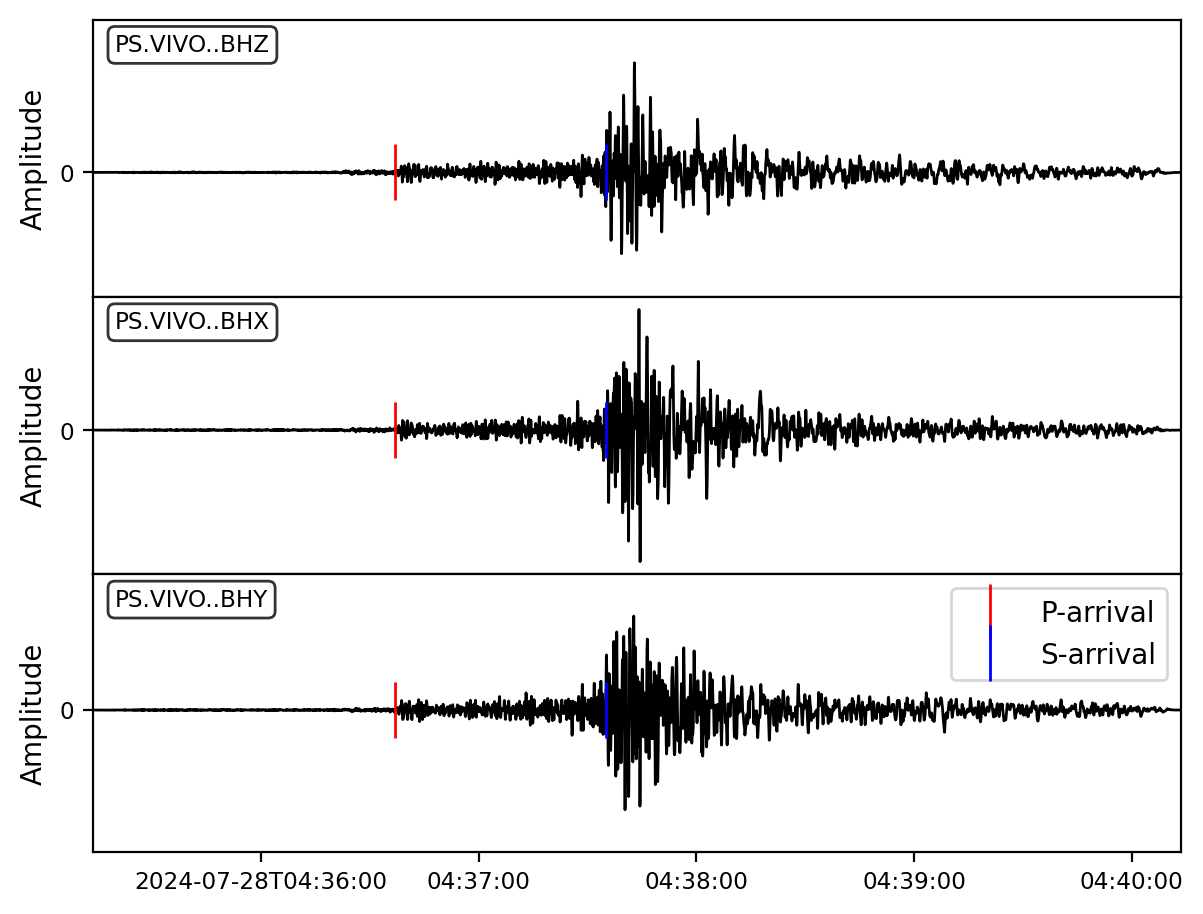

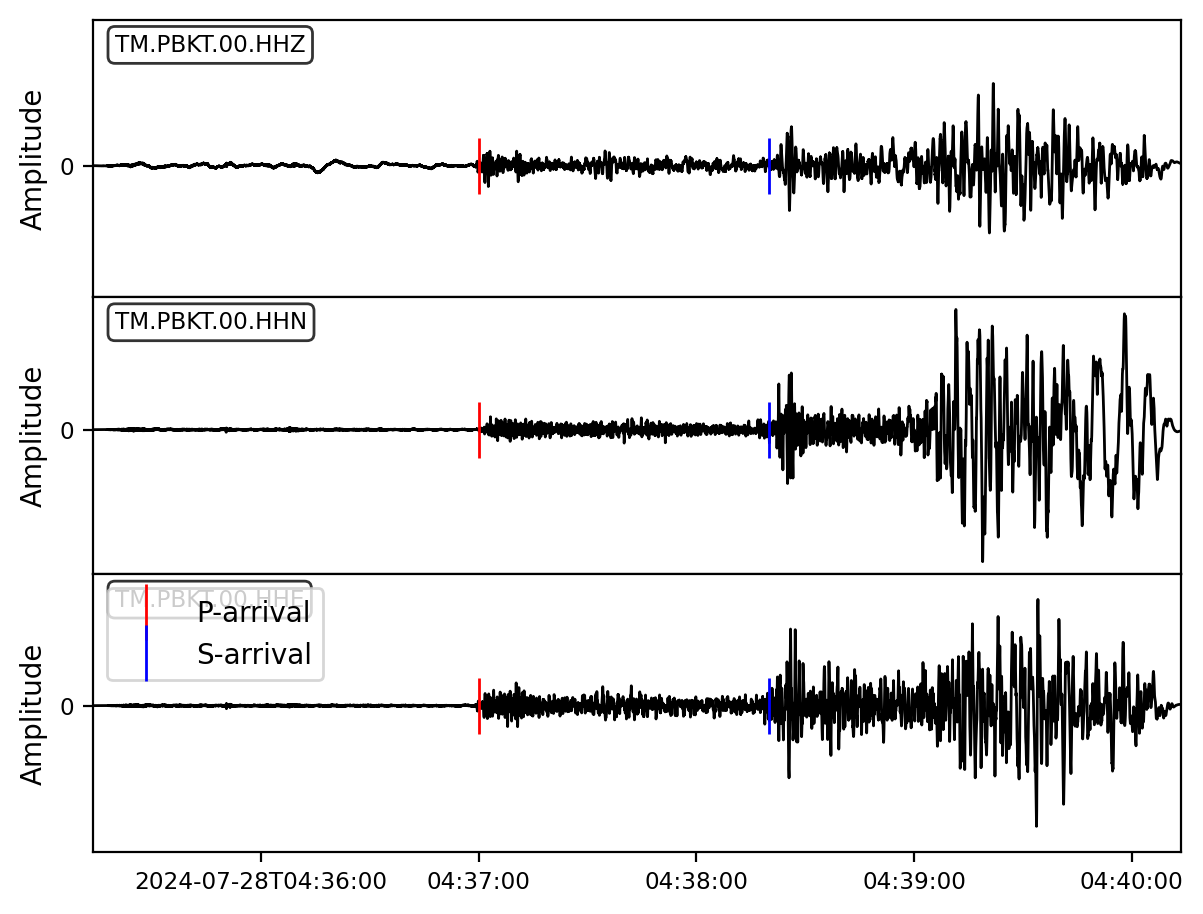

In [6]:
def plot_waveform(stacode, obs_data, filter_kw=dict(type='highpass', freq=0.1, corners=2, zerophase=False)):
    # plot the waveform
    st = dstream.select(station=stacode)
    # rotate the 3 orthogonal component seismograms to vertical (Z), north (N), and east (E) directions
    st.rotate('->ZNE', inventory=inv)
    # view the first 5 minutes of the seismograms from the origin time
    st.trim(origin_time, origin_time+300)
    # sequence to detrend, taper, and filter the seismoograms
    st.detrend('demean')
    st.taper(max_percentage=0.05)
    st.filter(**filter_kw)
    # plot the seismograms
    fig = plt.figure()
    st.plot(fig=fig)
    # mark the P and S arrival times
    for ax in fig.axes:
        # mark the P and S arrival times
        ax.plot(obs_data[stacode]['parv'].datetime, 0, 'r|', markersize=20, label='P-arrival')
        try:
            ax.plot(obs_data[stacode]['sarv'].datetime, 0, 'b|', markersize=20, label='S-arrival')
        except: # if the S-arrival is not provided
            pass
        # set the y-axis label
        ax.set(ylabel='Amplitude', yticks=[0])

    # show the figure legend
    ax.legend()
    plt.show()

## plot the seismograms
for key in obs_data.keys():
    plot_waveform(key, obs_data)

---
## Definite the forward problem

- input: hypocentral coordinates $(\theta, \phi)$
- ouput: differential travel time of S- and P- wave arrivals

We build the forward problem upon the `taup` software. `taup` is a classical package in global seismology to predict travel times of teleseismic phases in spherial Earth models. The package was origninally written in the Java programming language, which is packaged in `obspy` to allow pythonic interface.

In [7]:
from obspy.taup import TauPyModel
taup_model = TauPyModel(model="ak135")

## calculate the theoretical P and S arrival times for the stations
precomp_d = np.arange(0, 20.1, 0.5)
precomp_tp = np.zeros_like(precomp_d)
precomp_ts = np.zeros_like(precomp_d)
for i, d in enumerate(precomp_d):
    arrivals = taup_model.get_travel_times(0, d, ['P'])
    precomp_tp[i] = arrivals[0].time
    arrivals = taup_model.get_travel_times(0, d, ['S'])
    precomp_ts[i] = arrivals[0].time

For each hypocentral coordinate, the P and S travel time to each stations measured are computed using the taup `get_travel_times_geo` function. The prediction for each hypocentra will be S- to P- travel time differences corresponding to the observed stations.

In [8]:
def forward_prob(S):
    '''
    This forward problem returns the differential travel times of the S wave
    and P wave for a given epicenter location S observed at three stations 
    QIZ, VIVO, PBKT.
    '''
    src_lat, src_lon = S
    output = []
    for rcv in obs_data.values():
        # distance from receiver to source
        d = locations2degrees(src_lat, src_lon, rcv['lat'], rcv['lon'])
        # calculate the theoretical P and S arrival times
        t = np.interp(d, precomp_d, precomp_ts) - np.interp(d, precomp_d, precomp_tp)
        output.append(t)
    return np.array(output)

--- 
## Optimal inverse solution

First, we try to derive the inverse solution using optimizer. Here we use the `Nelder-Mead` algoritm from defined optimizers from the `scipy` package.

In [9]:
## pre-defined optimizer
from scipy.optimize import minimize

dt = np.array([v['tdiff'] for v in obs_data.values()])
## define the objective function
def objective_function(S):
    pred = forward_prob(S)
    return np.sum((dt - pred)**2)

## optimize the objective function using the Nelder-Mead method
S0 = (origin_lat, origin_lon)
res = minimize(objective_function, x0=S0, method='Nelder-Mead')

## print the result with defined format
print (f'Optimized epicenter location: Latitude = {res.x[0]:.4f}, Longitude = {res.x[1]:.4f}')
print (f'Success: {res.success}')
print (f'Message: {res.message}')
print (f'Number of function evaluations: {res.nfev}')
print (f'Number of iterations: {res.nit}')
print (f'Objective function value: {res.fun:.4f}')
# print (res)

Optimized epicenter location: Latitude = 14.8682, Longitude = 108.3389
Success: True
Message: Optimization terminated successfully.
Number of function evaluations: 64
Number of iterations: 32
Objective function value: 40.8030


Let's see how the optimal solution looks on a map.

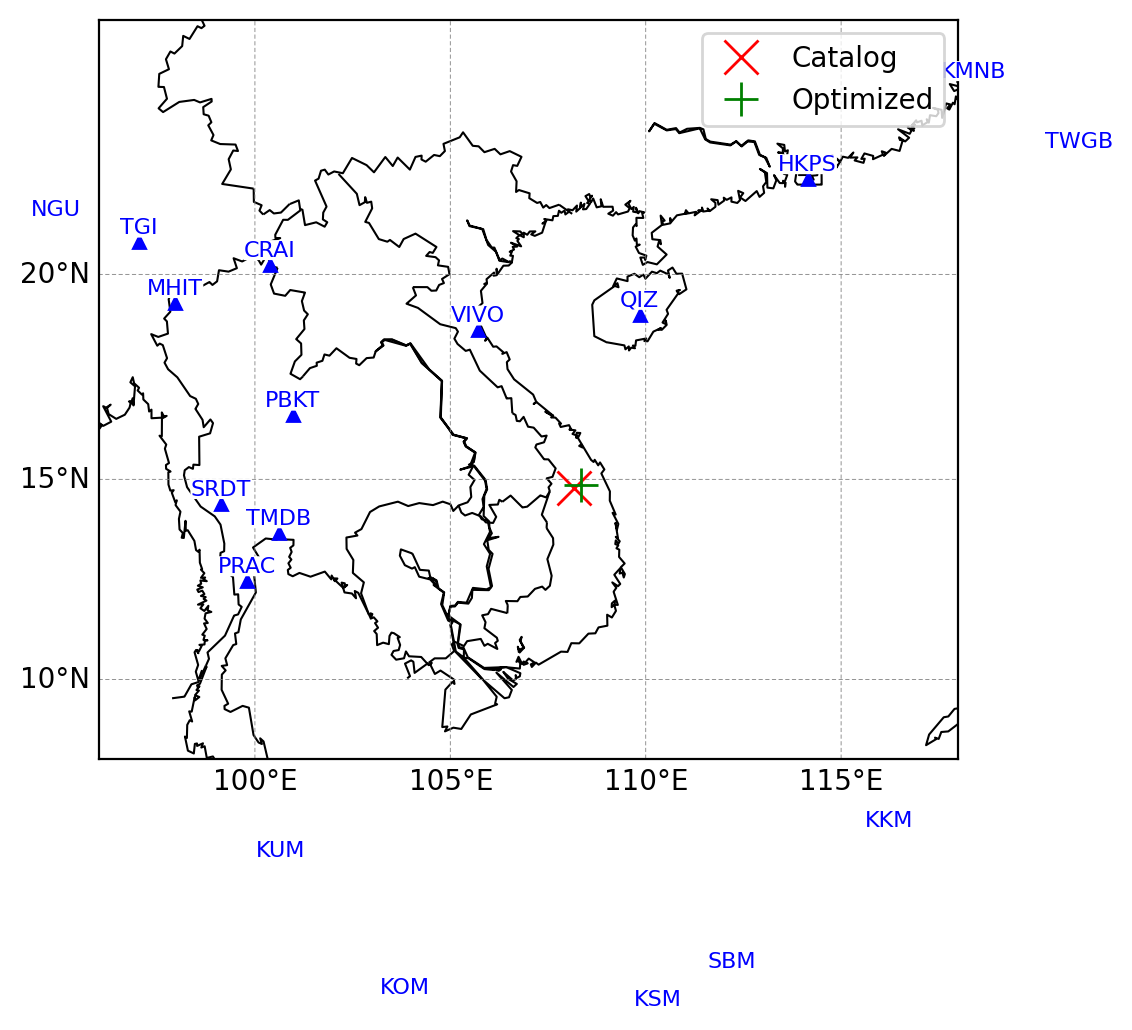

In [10]:
m = plot_map(inv, event)
m.plot(res.x[1], res.x[0], '+g', markersize=12, label='Optimized', latlon=True)
m.ax.legend(loc='upper right')
plt.show()

# Bayesian sampling and uncertainty estimates

In [11]:
lower_bound = (8, 94)
upper_bound = (24, 118)

def log_prior(S):
    '''
    This function computes the prior probability of the epicenter location S.
    '''
    if not (lower_bound[0] <= S[0] <= upper_bound[0] and lower_bound[1] <= S[1] <= upper_bound[1]): 
        return -np.inf 
    return 0 # uninformative prior within the map boundary

def log_likelihood(S, sigma=5):
    '''
    This function computes the log likelihood of the observed data given the
    epicenter location S.
    '''
    pred = forward_prob(S)
    sigma = np.ones_like(obs_data) * sigma
    return -.5 * np.sum((dt - pred)**2 / sigma**2 + np.log(2 * np.pi * sigma**2)) # Gaussian likelihood
    
def log_prob(X):
    '''
    This function computes the log likelihood of the observed data given an coordinate 
    in the parameter space.
    '''
    return log_prior(X) + log_likelihood(X, 10)

## initialize the walkers
nsteps = 400
nwalkers = 32

## number of dimensions, which is 2 for lat and lon of the epicenter
ndim = 2
walker_start = np.random.uniform(0, 1, (nwalkers, ndim))
for i in range(ndim): # uniform start
    walker_start[:, i] = walker_start[:, i] * (upper_bound[i] - lower_bound[i]) + lower_bound[i]

## run the MCMC
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_prob)
output = sampler.run_mcmc(walker_start, nsteps, progress=True)

100%|██████████| 400/400 [00:01<00:00, 205.99it/s]


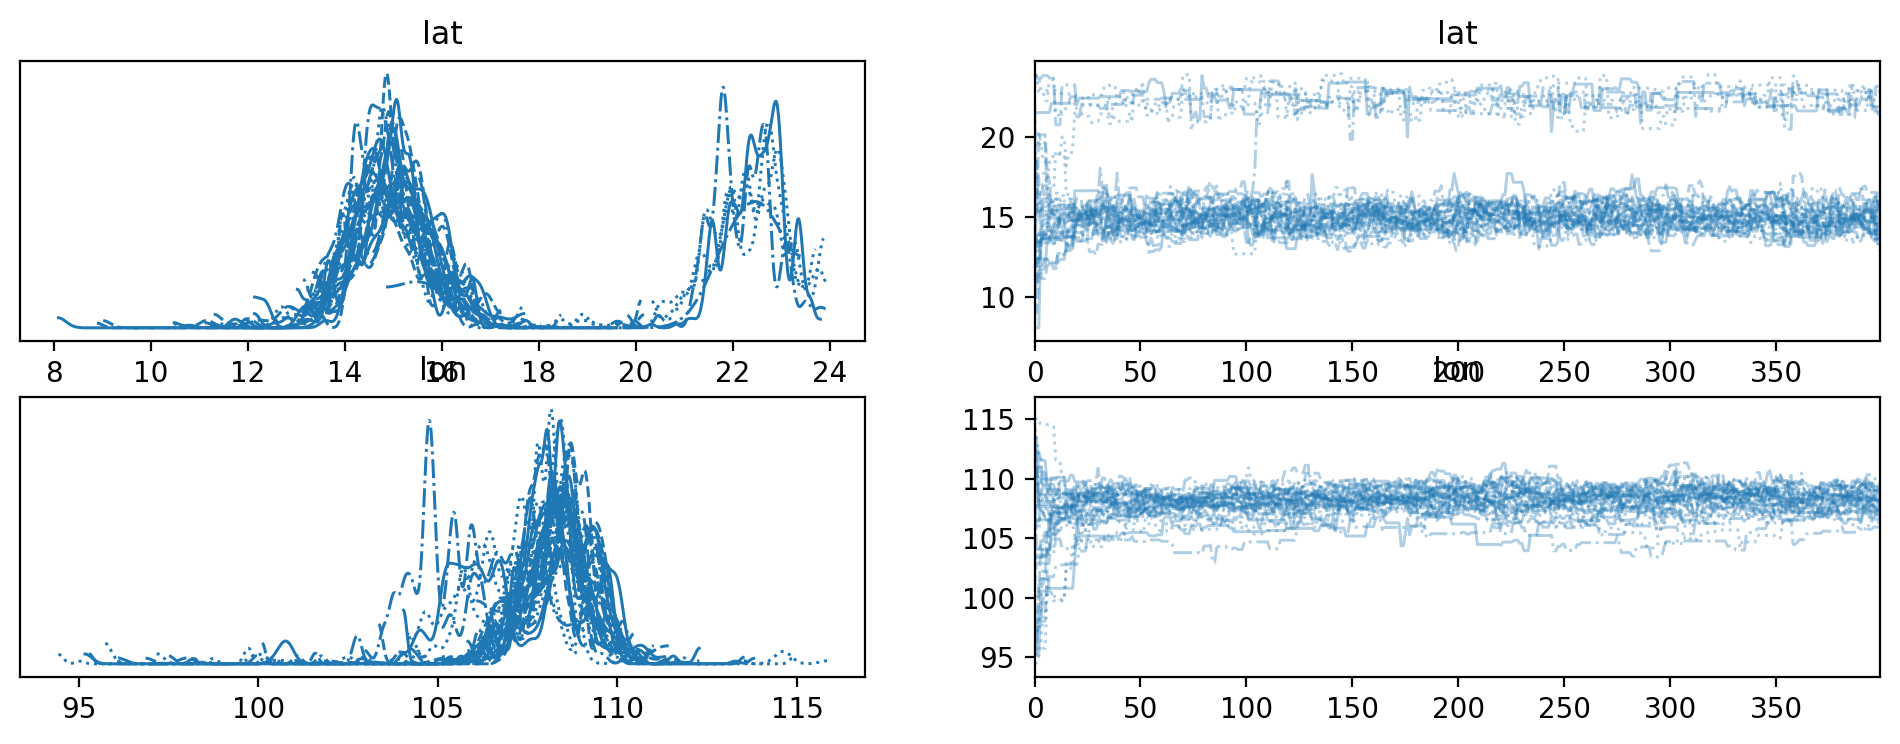

In [12]:
import arviz as az
idata = az.from_emcee(sampler, var_names=['lat', 'lon'])
ax = az.plot_trace(idata)
plt.show()

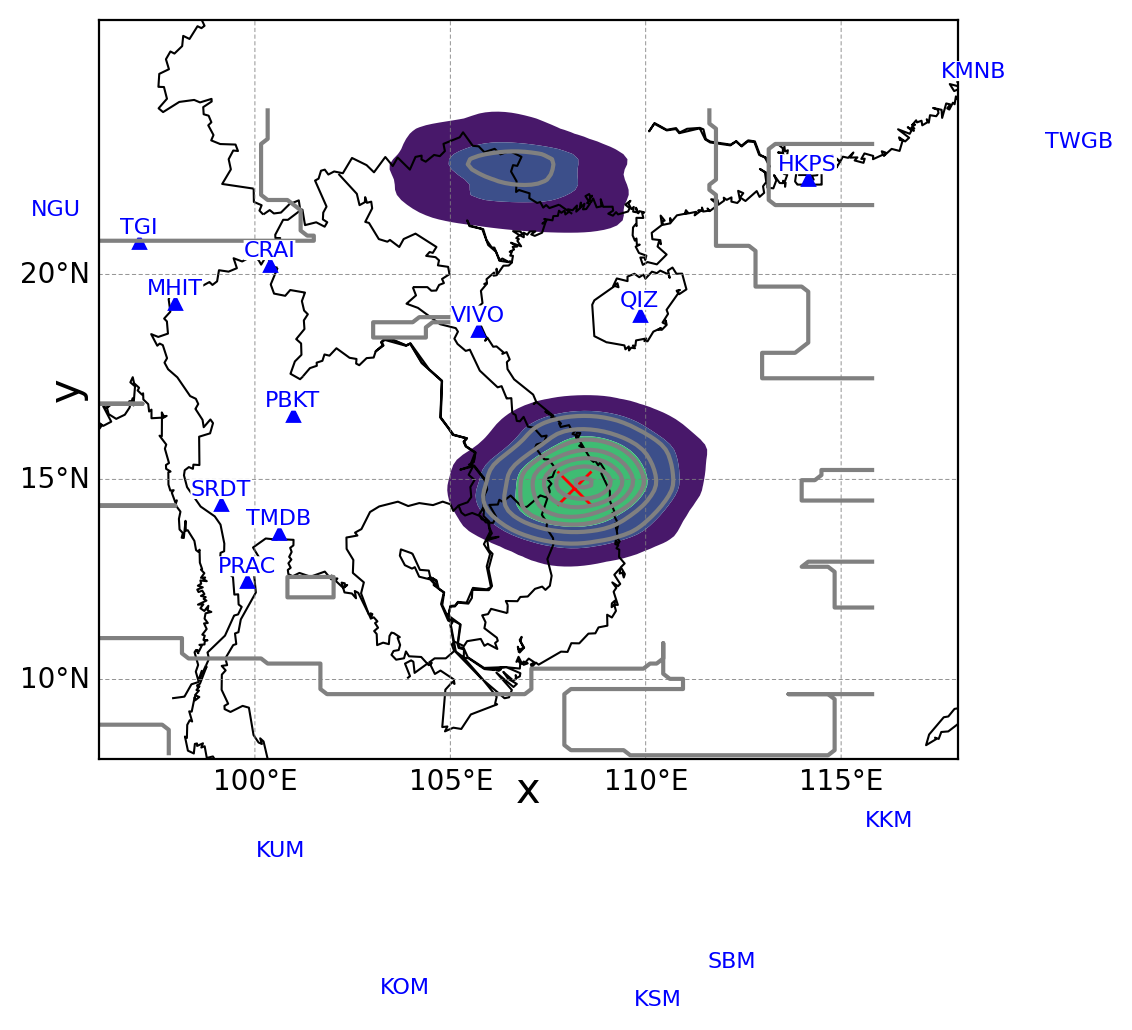

In [13]:
x, y = m(idata.posterior.lon.values, idata.posterior.lat.values)
m = plot_map(inv, event)
az.plot_pair({'x': x.flatten(), 'y': y.flatten()}, kind='kde', ax=m.ax, scatter_kwargs={'alpha': 0.1})
plt.show()

---

In [14]:
lower_bound = (8, 94, 0)
upper_bound = (24, 118, 20)

def log_prior(X):
    '''
    This function computes the prior probability of the epicenter location S.
    '''
    for i in range(len(X)):
        if not (lower_bound[i] <= X[i] <= upper_bound[i]): 
            return -np.inf
    return 0 # uninformative prior within the map boundary

def log_likelihood(X):
    '''
    This function computes the log likelihood of the observed data given the
    epicenter location S.
    '''
    pred = forward_prob(X[:2])
    sigma = np.ones_like(dt) * X[2]
    return -.5 * np.sum((dt - pred)**2 / sigma**2 + np.log(2 * np.pi * sigma**2)) # Gaussian likelihood
    
def log_prob(X):
    '''
    This function computes the log likelihood of the observed data given an coordinate 
    in the parameter space.
    '''
    return log_prior(X) + log_likelihood(X)

## initialize the walkers
nsteps = 1000
nwalkers = 32

## number of dimensions, which is 2 for lat and lon of the epicenter
ndim = 3
walker_start = np.random.uniform(0, 1, (nwalkers, ndim))
for i in range(ndim): # uniform start
    walker_start[:, i] = walker_start[:, i] * (upper_bound[i] - lower_bound[i]) + lower_bound[i]

## run the MCMC
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_prob)
output = sampler.run_mcmc(walker_start, nsteps, progress=True)

100%|██████████| 1000/1000 [00:04<00:00, 208.09it/s]


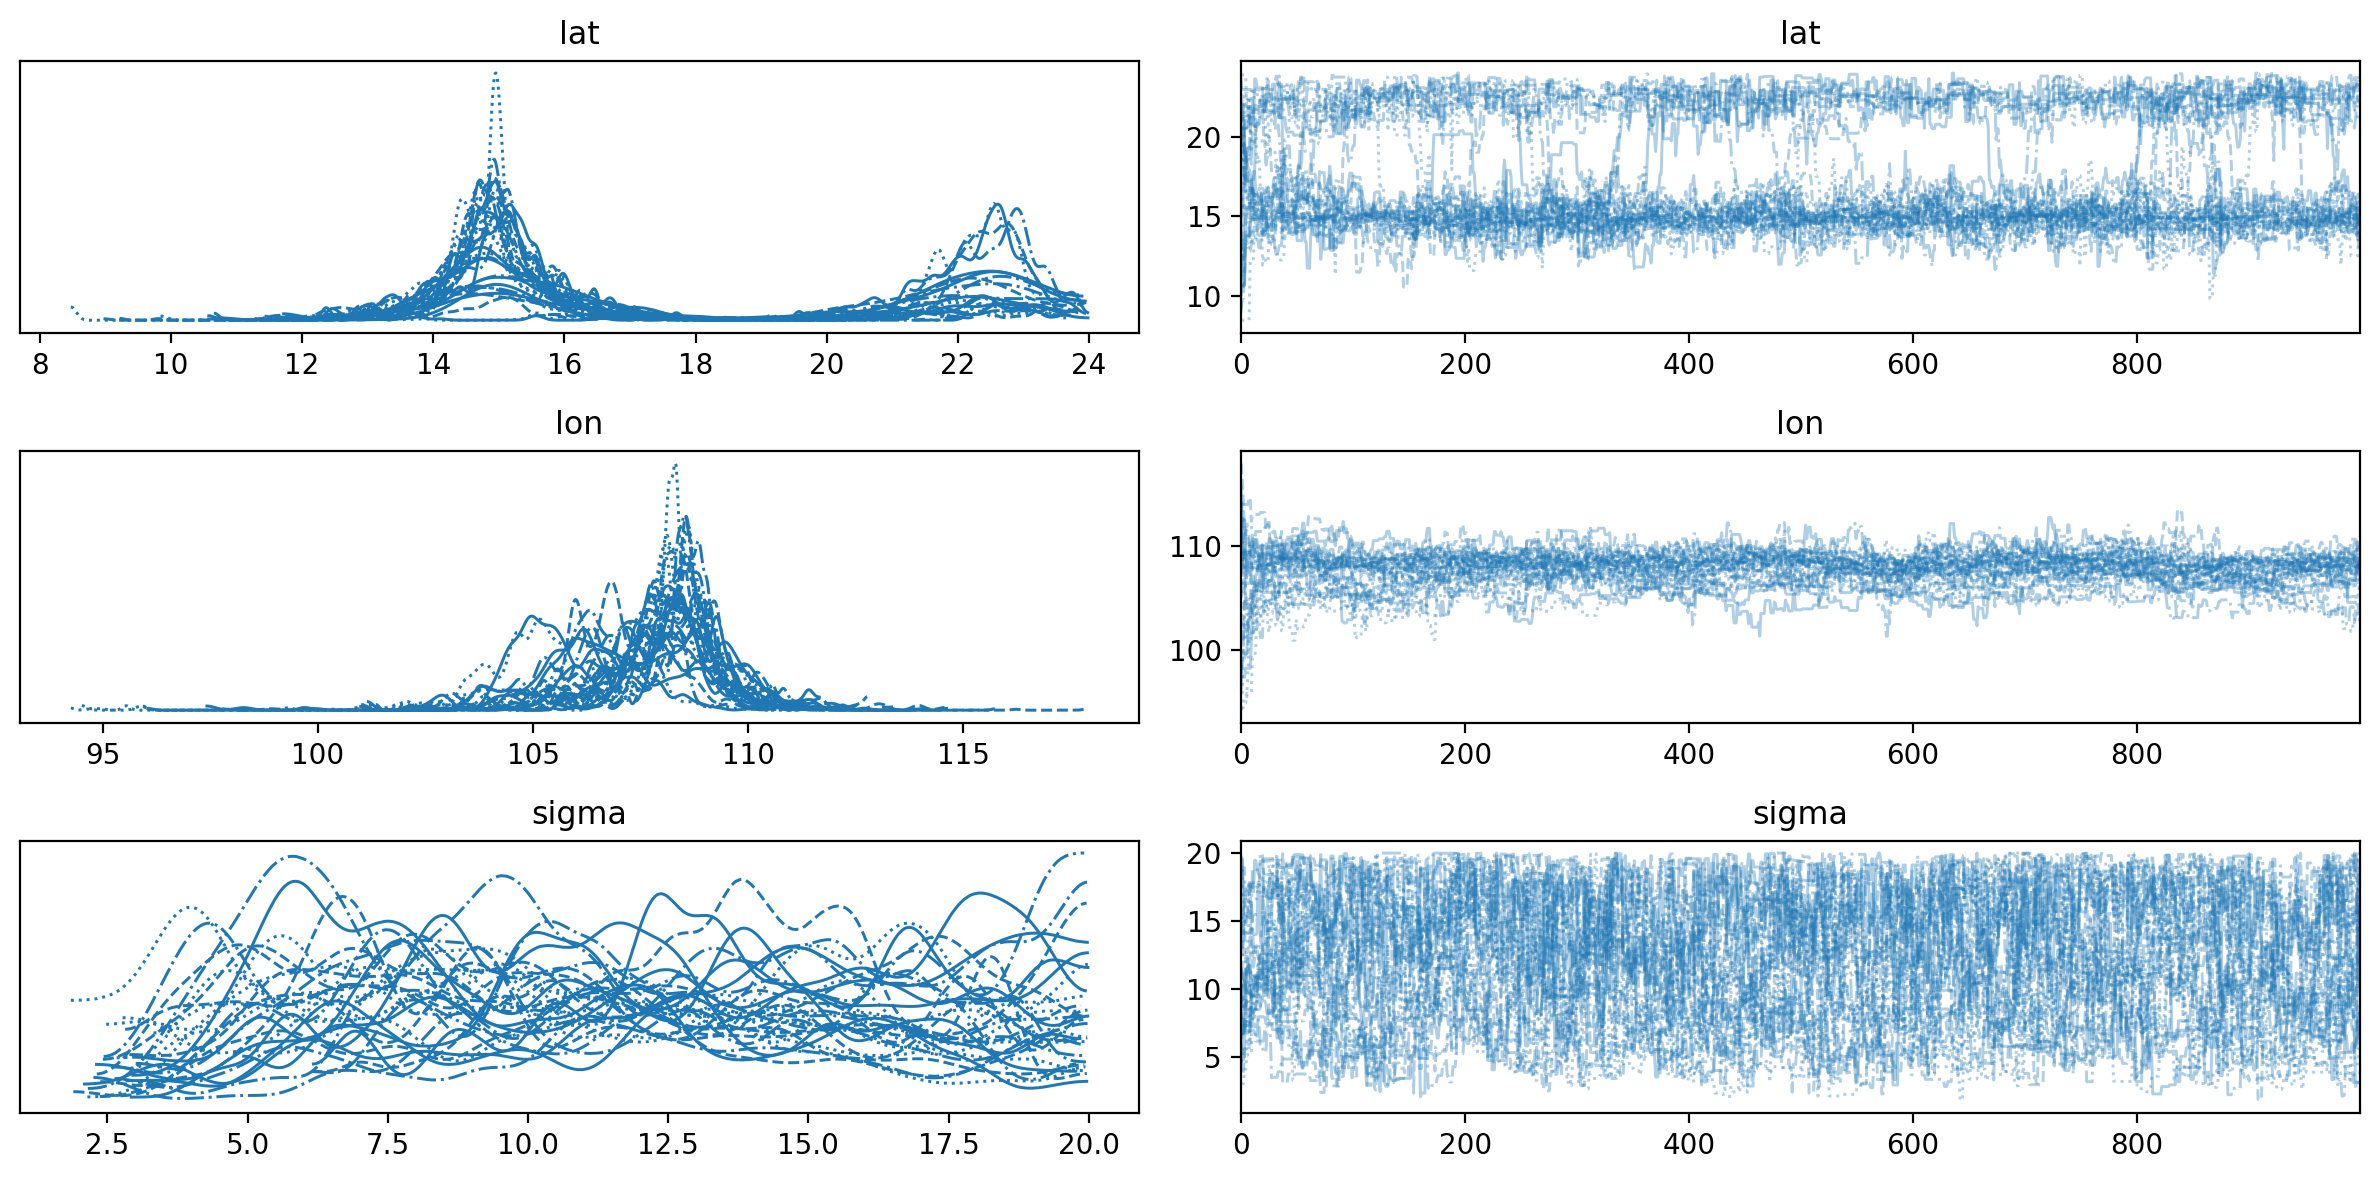

In [15]:
idata = az.from_emcee(sampler, var_names=['lat', 'lon', 'sigma'])
ax = az.plot_trace(idata)
plt.tight_layout()
plt.show()

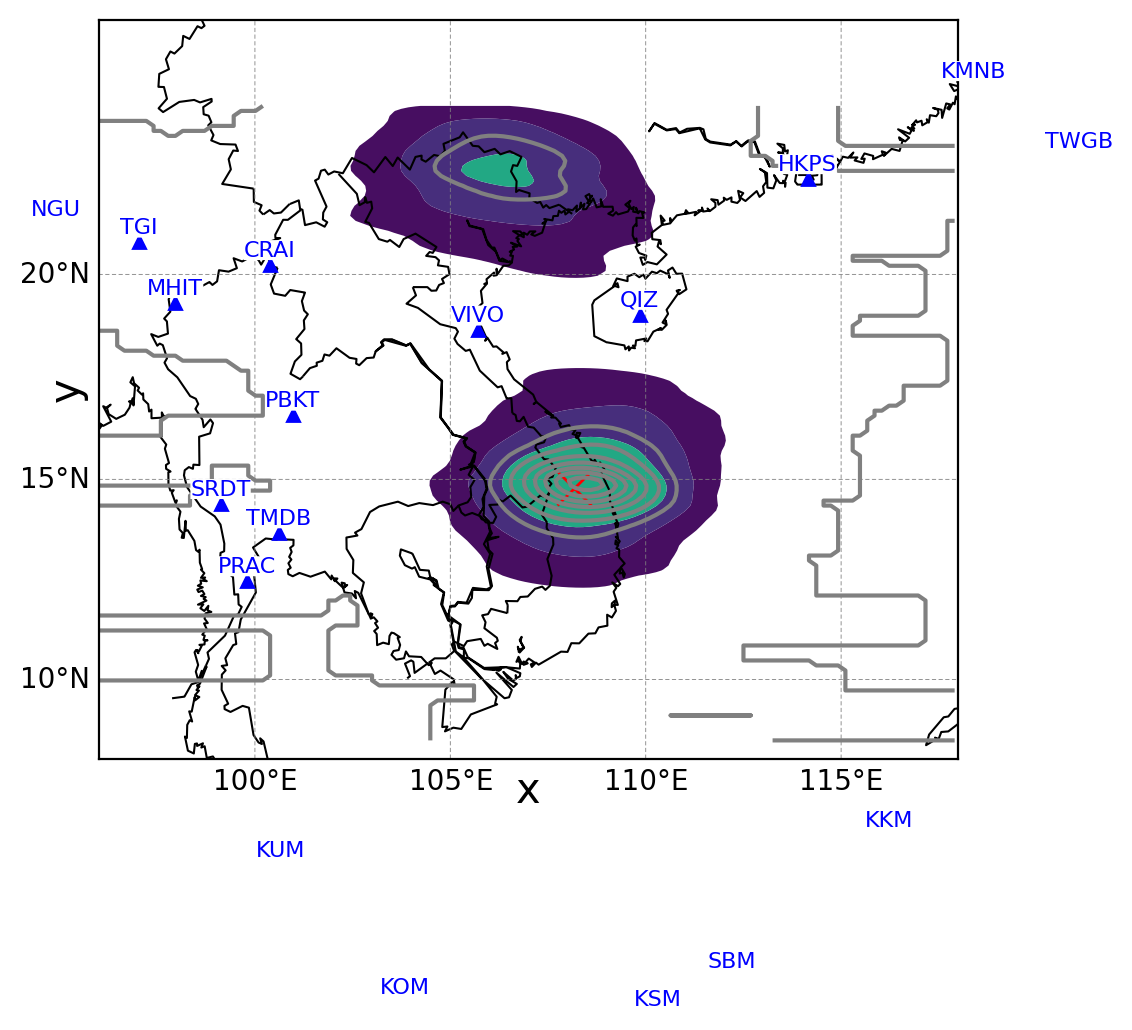

In [16]:
x, y = m(idata.posterior.lon.values, idata.posterior.lat.values)
m = plot_map(inv, event)
az.plot_pair({'x': x.flatten(), 'y': y.flatten()}, kind='kde', ax=m.ax, scatter_kwargs={'alpha': 0.1})
plt.show()

---
### Different forward problem

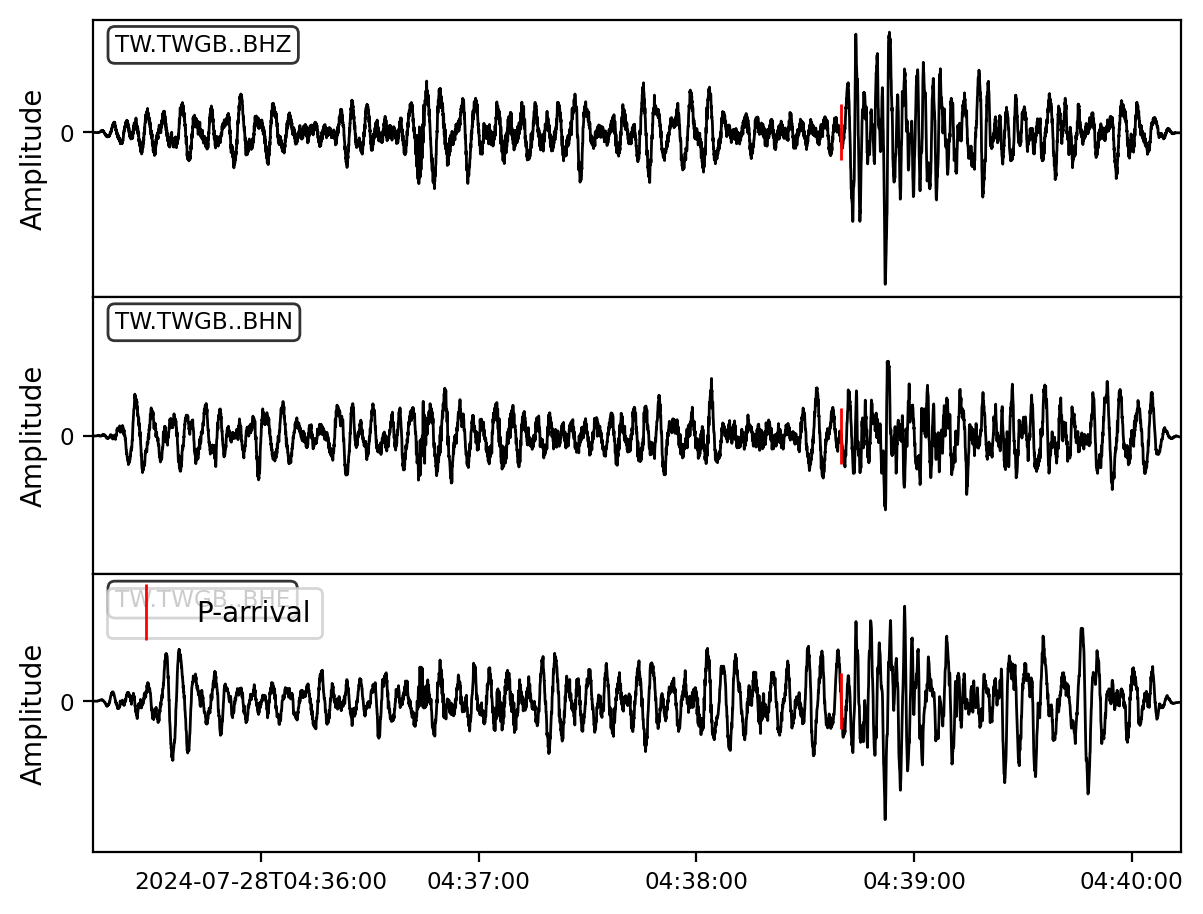

In [17]:
obs_data2 = {
    'TWGB': {'parv': UTCDateTime(2024,7,28,4,38,40)},
    'SBM': {'parv': UTCDateTime(2024,7,28,4,38,19)},
    'KKM': {'parv': UTCDateTime(2024,7,28,4,38,3)},
    'QIZ':  {'parv': UTCDateTime(2024,7,28,4,36,20)},
    'VIVO': {'parv': UTCDateTime(2024,7,28,4,36,37)},
    'PBKT': {'parv': UTCDateTime(2024,7,28,4,37,0)},
    }

# update the station coordinates from the inventory
for key, rcv in obs_data2.items():
    tmp = inv.select(station=key)
    obs_data2[key].update({'lat': tmp[0][0].latitude, 'lon': tmp[0][0].longitude})

## plot the seismograms
for key in obs_data2.keys():
    plot_waveform(key, obs_data2)#, filter_kw=dict(type='bandpass', freqmin=0.1, freqmax=1.0, corners=2, zerophase=False))
    break

100%|██████████| 1000/1000 [00:25<00:00, 39.63it/s]


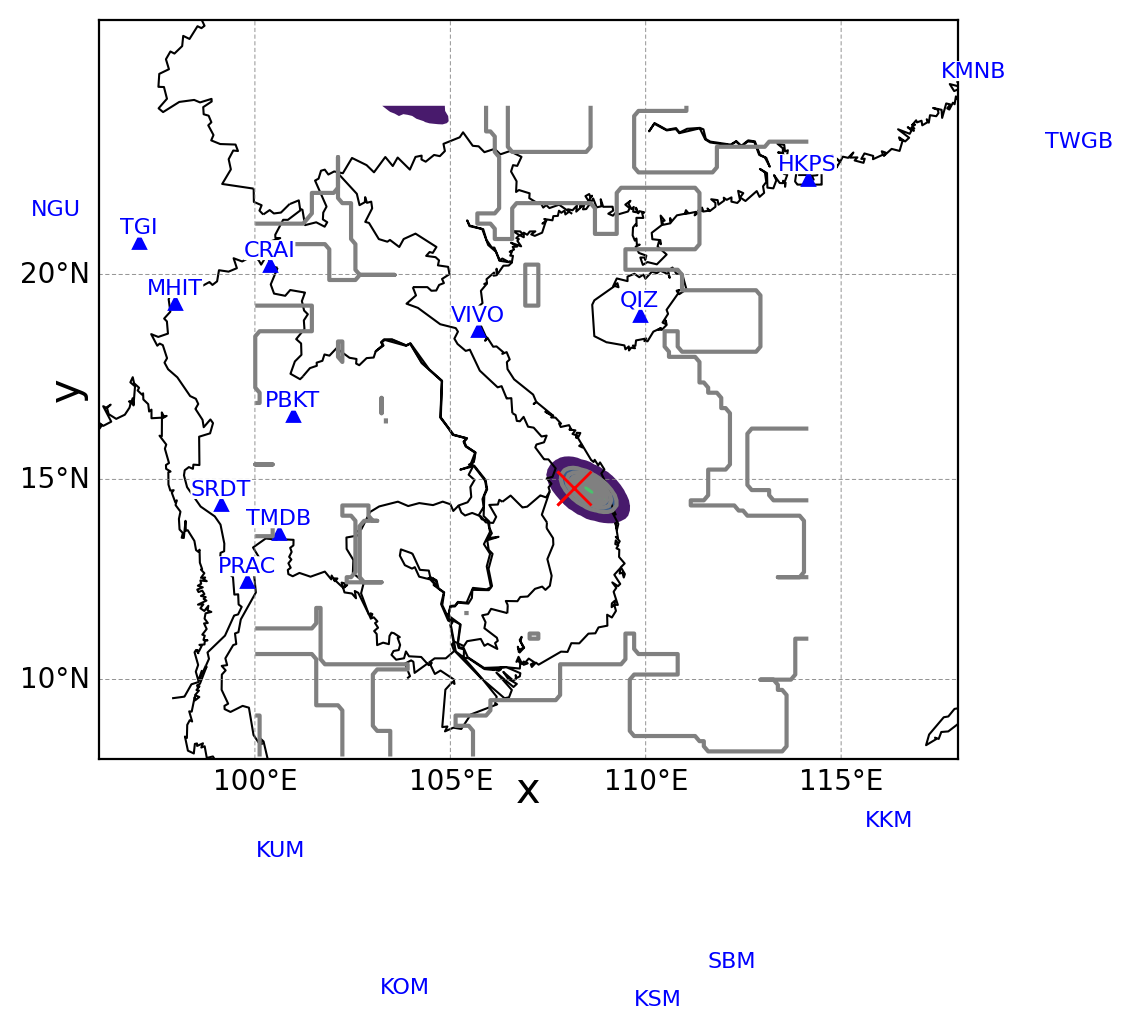

In [18]:
lower_bound = (8, 100, 0)
upper_bound = (24, 115, 20)

def forward_prob2(S):
    '''
    This forward problem returns the differential travel times of the S wave
    and P wave for a given epicenter location S observed at three stations 
    QIZ, VIVO, PBKT.
    '''
    src_lat, src_lon = S[:2]
    tp_pred = []
    for rcv in obs_data2.values():
        # distance from receiver to source
        d = locations2degrees(src_lat, src_lon, rcv['lat'], rcv['lon'])
        # calculate the theoretical P and S arrival times
        tp_pred.append(np.interp(d, precomp_d, precomp_tp))
    return  np.array(tp_pred)

def log_likelihood2(X):
    '''
    This function computes the log likelihood of the observed data given the
    epicenter location S.
    '''
    tp_pred = forward_prob2(X)
    tp = np.array([v['parv'] for v in obs_data2.values()])

    idx = np.triu_indices(len(tp_pred), 1)

    tp_pred = tp_pred[idx[0]] - tp_pred[idx[1]]
    # print ('pred', tp_pred.astype(int))
    tp = tp[idx[0]] - tp[idx[1]]
    # print ('obs', tp.astype(int))

    sigma = X[2] * np.ones_like(tp_pred)
    return -.5 * np.sum((tp - tp_pred)**2 / sigma**2 + np.log(2 * np.pi * sigma**2)) # Gaussian likelihood

def log_prob2(X):
    '''
    This function computes the log likelihood of the observed data given an coordinate
    in the parameter space.
    '''
    return log_prior(X) + log_likelihood2(X)

# print (log_prob2([origin_lat, origin_lon, 5]))
## initialize the walkers
nsteps = 1000
nwalkers = 64

## number of dimensions, which is 2 for lat and lon of the epicenter
ndim = 3
walker_start = np.random.uniform(0, 1, (nwalkers, ndim))
for i in range(ndim): # uniform start
    walker_start[:, i] = walker_start[:, i] * (upper_bound[i] - lower_bound[i]) + lower_bound[i]

## run the MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_prob2)
output = sampler.run_mcmc(walker_start, nsteps, progress=True)

idata = az.from_emcee(sampler, var_names=['lat', 'lon', 'sigma'])
# ax = az.plot_trace(idata)
# plt.tight_layout()

x, y = m(idata.posterior.lon.values, idata.posterior.lat.values)
m = plot_map(inv, event)
az.plot_pair({'x': x.flatten(), 'y': y.flatten()}, kind='kde', ax=m.ax, scatter_kwargs={'alpha': 0.1})
m.plot(event.preferred_origin().longitude, event.preferred_origin().latitude,
       'rx', markersize=12, label='Catalog', latlon=True)
plt.show()